# Introduction

This is a supplemental notebook for the lectures on Principal Component Analysis (PCA) and Probabilistic Principal Component Analysis (PPCA). It tries to provide a (nearly) from-scratch implementation of these two algorithms using NumPy.

For information on what PCA is and the derivation of the PCA algorithm, here are some useful resources:
- https://www.youtube.com/watch?v=FD4DeN81ODY (Intuition of PCA)
- https://people.math.ethz.ch/~abandeira/BandeiraSingerStrohmer-MDS-draft.pdf   Section 3.2 (The math behind the PCA algorithm)
- Class lectures and previous notebook on PCA (If you need more perspectives on the intuition and the math)


For probabilistic PCA, I could not find a good resource online, well may be this: https://www.tensorflow.org/probability/examples/Probabilistic_PCA

The course textbook ("Probabilistic Machine Learning: An Introduction", Kevin P. Murphy) does a good job explaining the concepts and math behind it. It is a bit heavy on the math side, so I recommend reading the following sections from the book before reading the PPCA section. At least for me, they clarified a lot of the notation and mathematical concepts used.
- 2.3 Bayes' Rule
- 3.2 The multivariate Gaussian (normal) distribution
- **3.3 Linear Gaussian systems (PLEASE READ THIS)**
- **4.2 Maximum likelihood estimation (ALSO PLEASE READ THIS)**
- 20.2 Factor Analysis (Is a general case of probabilistic PCA)

If learning by reading is not your thing, I have tried to compile a few video resources on _some_ of the above topics:
- https://www.youtube.com/watch?v=eho8xH3E6mE (Intro to multivariate Gaussians)
- https://www.youtube.com/watch?v=jjsrhOpHalM (Affine transformations of multivariate Gaussians)
- https://www.youtube.com/watch?v=93fPFOf547Q (Maximum Likelihood Estimation Basics)

## PCA recap

I'll start with a brief recap of the PCA algorithm. Remember that if you have a collection of D-dimensional vectors x<sub>1</sub>, ... ,x<sub>N</sub> ∈ R<sup>D</sup> and you want to project them onto an L-dimensional subspace of R<sup>D</sup>, you have to perform the following steps:
1. Place each x<sub>i</sub> in its own column, join the columns together to form a data matrix X: **X = [x<sub>1</sub>, x<sub>2</sub>, ... , x<sub>N</sub>]**
2. Calculate the mean column of X: **μ = (x<sub>1</sub> + x<sub>2</sub> + ... + x<sub>N</sub>) / N**
3. Subtract μ, the mean column of X, from each column of X to make X mean-centered (i.e. the columns now have 0 mean): **x<sub>i</sub> = x<sub>i</sub> - μ**
4. Calculate the covariance matrix S of the mean-centered data matrix: **S = (1/N) * XX<sup>T</sup>**
    - S is a symmetric, positive semi-definite matrix
5. Calculate the eigenvalues and eigenvectors of S: **Sv = λv**
6. Sort the eigenvectors of S by descending eigenvalues
    - The L eigenvectors of S with the highest eigenvalues gives the L principal components of X
7. To actually use the principal components, follow these steps:
    - Create matrix W with the top L NORMALIZED eigenvectors: **W = [v<sub>1</sub>, v<sub>2</sub>, ... , v<sub>N</sub>], ||v<sub>i</sub>|| = 1**
    - To find the L-dimensional representation z ∈ R<sup>L</sup> of a D-dimensional vector x ∈ R<sup>D</sup>: **z = W<sup>T</sup>x**
    - To find π(x) ∈ R<sup>D</sup>, the projection of x ∈ R<sup>D</sup> onto the L-dimensional subspace (reconstruction of x): **π(x) = WW<sup>T</sup>x + μ**

## Probabilistic PCA (PPCA) recap

Probabilistic PCA is a generative version of PCA. That is, it can not only create lower-dimensional representations of data, but also generate new samples of data by learning the underlying probability distribution. Again, I will not be going into the mathematical details here, but will instead provide a brief recap of the steps involved in PPCA. As with the PCA case, if you have a collection of D-dimensional vectors x<sub>1</sub>, ... ,x<sub>N</sub> ∈ R<sup>D</sup> and you want to project them onto an L-dimensional subspace of R<sup>D</sup>, and generate new D-dimensional samples y<sub>1</sub>, ... ,y<sub>M</sub> ∈ R<sup>D</sup>, you have to perform the following steps:
1. Assume that the D-dimensional data is generated using an L-dimensional multivariate Gaussian distribution z, with mean vector 0 and covariance matrix of I (identity matrix): **z ~ N(0, I<sub>L</sub>) ∈ R<sup>L</sup>**
2. For a given value of z, assume that a D-dimensional output x is generated using the affine transformation Wz + μ, with some random noise Ψ:
    - **x | z ~ N(Wz + μ, Ψ)**
    - **x = Wz + μ + Random Noise**
    - W ∈ R<sup>DxL</sup> is called a factor-loading matrix. It has D rows and L columns
    - μ ∈ R<sup>D</sup> is the mean
    - Ψ ∈ R<sup>DxD</sup> is a diagonal covariance matrix representing the noise in the transformation
    - **Ψ = σ<sup>2</sup>I<sub>D</sub>**, where I<sub>D</sub> is the D x D identity matrix
3. From the above information, we can find out the marginal distribution of x:
    - **x ~ N(μ, WW<sup>T</sup> + σ<sup>2</sup>I<sub>D</sub>)**    
4. Since we have N samples/observations of x: x<sub>1</sub>, ... ,x<sub>N</sub>, we can calculate maximum likelihood estimates for μ, W and σ<sup>2</sup>
    - Maximum likelihood estimate of mean is just the sample mean
        - **μ = (x<sub>1</sub> + x<sub>2</sub> + ... + x<sub>N</sub>) / N**
    - Maximum likelihood estimate of variance of given by:
$$\sigma^{2}=\frac{1}{D-L}\sum_{i=L+1}^{D}\lambda_{i}$$ 
    - Maximum likelihood estimate of W is given by:
        - **W = U<sub>L</sub>(L<sub>L</sub>−σ<sup>2</sup>I<sub>L</sub>)<sup>1/2</sup>**
        - U<sub>L</sub> ∈ R<sup>DxL</sup>: L eigenvectors of S, the sample covariance matrix, with the highest eigenvalues
        - L<sub>L</sub> ∈ R<sup>LxL</sup>: Diagonal matrix consisting of the top L eigenvalues of S, the sample covariance matrix
        - σ<sup>2</sup> ∈ R: Maximum likelihood estimate of variance
        - I<sub>L</sub> ∈ R<sup>LxL</sup>: L x L identity matrix

# Dataset

For this notebook, we will be working with the Olivetti Faces dataset. It is an open-source dataset consisting of 400 images of faces of various people. There are several reasons I chose this dataset:

1. It is free
2. The scikit-learn Python package provides an easy way to load this dataset, so you can play with it by yourself if you want to
3. Visual data gives us a great visual way to understand what exactly PCA is doing (I promise, you will see later)

# Loading Modules

In [1]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import random

# Fetching the dataset

In [2]:
x = fetch_olivetti_faces()

# Dataset Information

In [3]:
print(x['DESCR'])

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes    

# Extracting the data

In [4]:
faces = fetch_olivetti_faces()

"""
In the original data, each row contains a unique face.
After transposing the data, each individual face is in a column of X.
"""
X = np.matrix(faces['data']).T 
N = X.shape[1]  # Number of individual images
width = height = int(np.sqrt(X.shape[0]))  # Height and width of each individual image
D = X.shape[0]  # Original dimensionality of data

# Printing data dimension information
print(f"Data matrix X has a shape of {X.shape} ({N} columns, each containing an image of {D} pixels - a {width} x {height} image)")

Data matrix X has a shape of (4096, 400) (400 columns, each containing an image of 4096 pixels - a 64 x 64 image)


# Visualizing the data

Now that we have the data, usually the best thing to do is to check out and (if possible) visualize some random samples. 

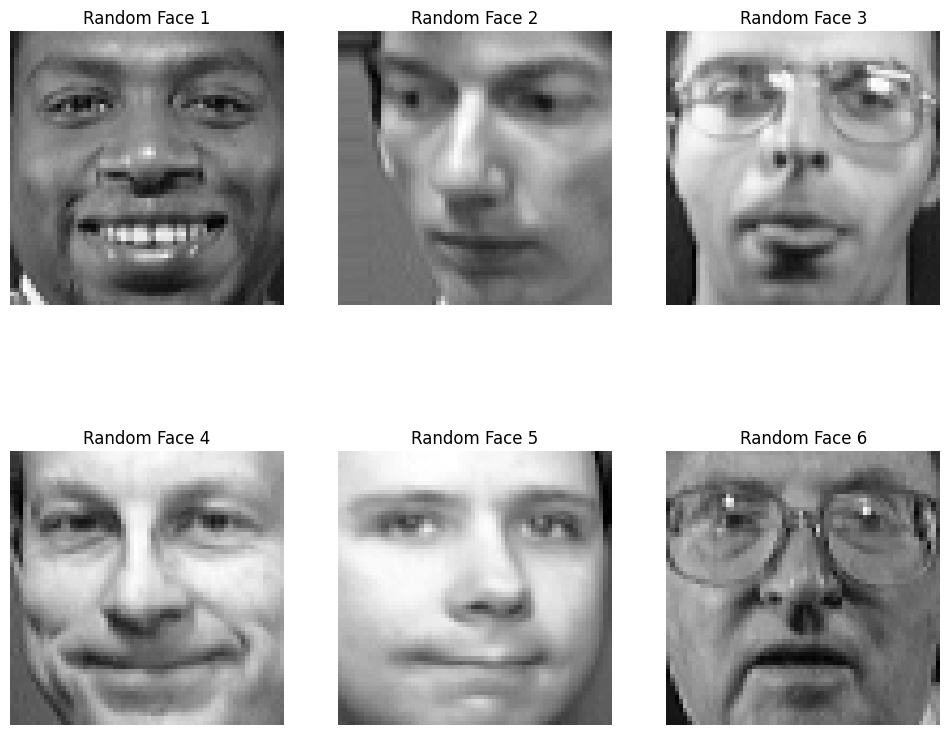

In [5]:
# Draw 6 random faces from the data
fig, axes = plt.subplots(2, 3, figsize=(12, 10))

for i in range(6):
    axes[i // 3][i % 3].set_title(f"Random Face {i+1}")
    axes[i // 3][i % 3].imshow(X[:, random.randint(0, N - 1)].reshape(64, 64), cmap="gray")  # Reshape 4096-dimensional vector to a 64x64 grid
    axes[i // 3][i % 3].axis("off")

# Centering the data, computing covariance matrix & plotting mean face

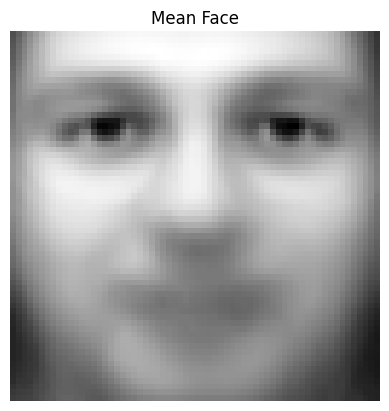

In [6]:
mu = np.mean(X, axis=1)  # Mean column/face
X -= mu  # Subtract each column by mean, making each column have 0 mean
S = np.cov(X, bias=True)  # Covariance matrix = S = (1/N)XX^T (Assuming X has centered columns)

# Display the mean face
plt.title("Mean Face")
plt.imshow(mu.reshape(64, 64), cmap="gray")
plt.axis("off")
plt.show()

# Get principal components and sort principal components based on eigenvalues

In [7]:
eigenvalues, eigenvectors = np.linalg.eigh(S) # Principal components are eigenvalues of covariance matrix S

idx = np.argsort(eigenvalues)[::-1]  # Get indices that would sort eigenvalues in descending order

sorted_eigenvalues = eigenvalues[idx]  # Apply sorting to eigenvalues
sorted_eigenvalues[sorted_eigenvalues < 0] = 0  # Covariance matrix is positive definite: should not have negative eigenvalues

sorted_eigenvectors = eigenvectors[:, idx]  # Reorder eigenvectors based on sorted indices

# Finding Optimum Value for L

Finding the optimum number of dimensions L to project onto is important. If L is too low, we might be discarding crucial features/patterns within the data. If L is too high, we might be storing redundant dimensions that do not contribute anything meaningful.

There are two ways to visualize the portion of information captured by a given number of dimensions: scree plots and proportion-of-variance plots.

## Scree Plot

A scree plot plots the eigenvalues of the covariance matrix in descending order. It is useful if we want to get a sense of the relative sizes of the eigenvalues.

We will only be plotting the first 50 eigenvalues, since the rest are too small relative to the biggest one to register meaningfully on the graph.

Note: all eigenvalues will be non-negative, since the covariance S is a positive semi-definite matrix (all eigenvalues >= 0)

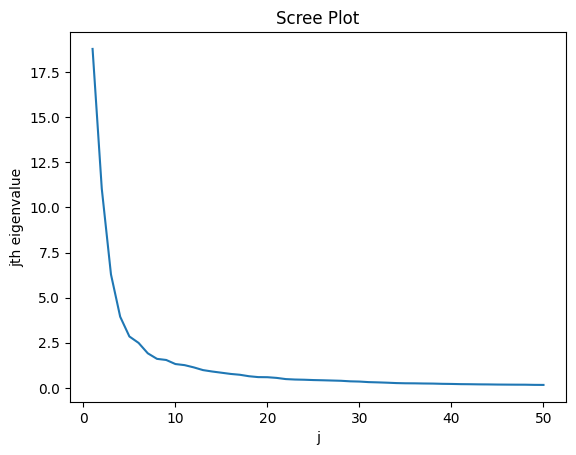

In [8]:
plt.title('Scree Plot')
plt.plot(range(1, 51), sorted_eigenvalues[:50])  # Plot top 50 eigenvalues
plt.xlabel('j')
plt.ylabel('jth eigenvalue')
plt.show()

## Plotting fraction of explained variance

The goal of PCA is to identify the few dimensions that capture the highest amount of covariance/patterns within the data, while discarding the rest. There is a way to quantify the proportion of the "patterns" that are captured by an L-dimensional representation, called th proportion of explained variance.

If there are D dimensions of the data, and we are projecting it onto L eigenvectors of the data covariance matrix S, the proportion of variance captured by that projection is given by:

$$F_{L}=\frac{\sum_{i=1}^{L}\lambda_{i}}{\sum_{j=1}^{D}\lambda_{j}}$$

Simply put, if you sum the eigenvalues corresponding to those L eigenvectors, and divide it by the total sum of all the eigenvectors, you will get the fraction of variance that is captured by those L eigenvectors.

## Picking L based on fraction of explained variance

Usually, we want to pick the minimum number of dimensions L that capture a certain portion of the variance of the data. For example, we can pick the fewest number of dimensions L that capture:
- 90% of the variance
- 95% of the variance
- 99% of the variance

The graph below plots the number of dimensions L against the proportion of variance captured by those L dimensions. As you will see, picking L = 150 roughly captures around 95% of the variance, while picking L = 300 captures around 99%.

**Take a second to think about this.** Our data was originally 4096-dimensional. By picking only 300 relevant dimensions, we were able to capture 99% of the information while achieving a more than 12x decrease in size!!

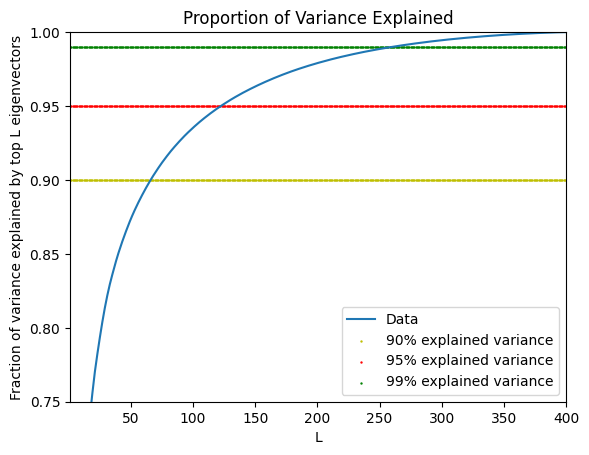

In [9]:
fractions = []  # Store fraction of explained variance for increasing L
running_eigval_sum = 0  # Running sum of top eigenvalues of covariance matrix S
total_eigval_sum = sum(sorted_eigenvalues)  # Sum of all eigenvalues of covariance matrix S

l_min = 1  # Minimum L we are considering
l_max = 400  # Maximum L we are considering
l_interval = range(l_min, l_max + 1)  # Range of possible L we are considering

# Calculating fractions of explained variance for different L
for L in l_interval:
    running_eigval_sum += sorted_eigenvalues[L - 1]  # Add current eigenvalue to running sum
    explained_variance_fraction = running_eigval_sum / total_eigval_sum  # Divide by the total sum to get the fraction of variance
    fractions.append(explained_variance_fraction) 

# Plot the data
plt.title('Proportion of Variance Explained')
plt.plot(l_interval, fractions, label="Data")
plt.scatter(l_interval, len(l_interval) * [0.9], s=0.5, color='y', label="90% explained variance")
plt.scatter(l_interval, len(l_interval) * [0.95], s=0.5, color='r', label="95% explained variance")
plt.scatter(l_interval, len(l_interval) * [0.99], s=0.5, color='g', label="99% explained variance")
plt.ylim([0.75, 1])
plt.xlim([1, l_max])
plt.xlabel('L')
plt.ylabel('Fraction of variance explained by top L eigenvectors')
plt.legend(loc=4)
plt.show()

In [36]:
L = 300
U_L = sorted_eigenvectors[:, :L]
L_L = np.diag(sorted_eigenvalues[:L])
sigma_sq = sum(sorted_eigenvalues[L:]) / (D - L)
psi_L = sigma_sq * np.eye(L)
psi_D = sigma_sq * np.eye(D)

W_pca = U_L
W_prob_pca = U_L @ np.sqrt(L_L - psi_L)
C = W_prob_pca @ W_prob_pca.T + psi_D

mu_list = [x[0] for x in np.array(mu)]

# Visualizing "Eigenfaces"

Here is the visual intuition of PCA that I promised at the beginning. So what exactly are these "principal components" that we are finding? Sure, they are the vectors that capture the highest amount of variance, but what does it mean in practice? 

In the graph below, you will see that I have drawn the top 6 principal components. You might very well ask, WHAT? How can I "draw" a principal component? Think about it. Our original data was faces. They were 4096 dimensional vectors, which we resized into 64x64 grids and displayed using matplotlib's _imshow_ function.

Now think about what the principal components are. These are the vectors in 4096-dimensional space along which the data varies the most. Hence, they are also 4096-dimensional vectors themselves, and so can by resized into 64x64 grids and drawn.

Let's see what they look like. They are a bit creepy, though.

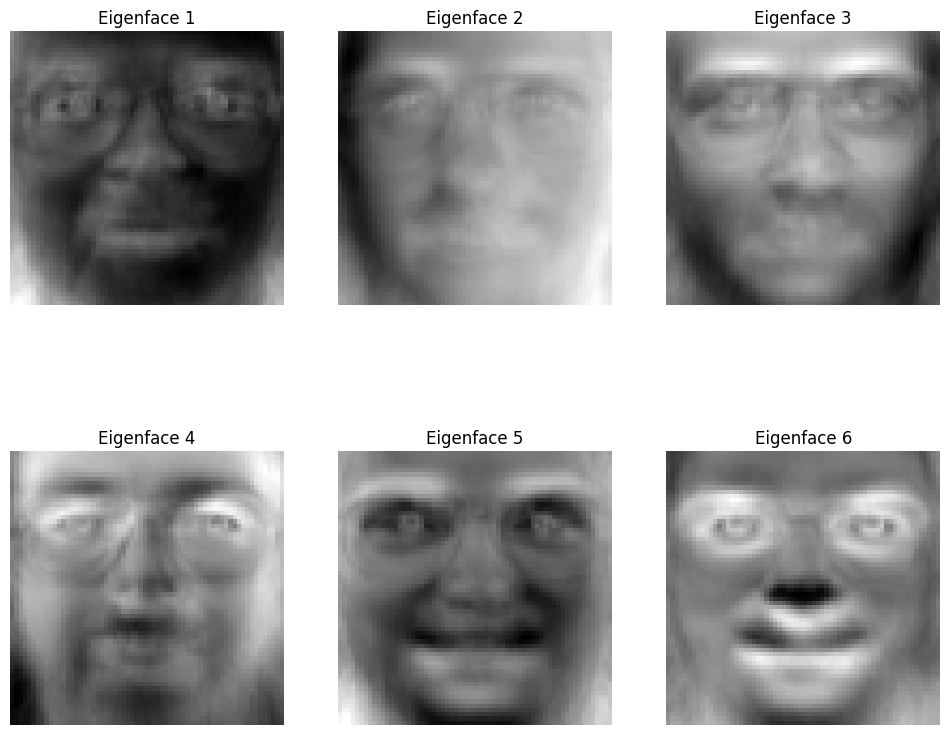

In [12]:
# Draw 6 most "descriptive" principal components (eigenfaces)
fig, axes = plt.subplots(2, 3, figsize=(12, 10))

for i in range(6):
    axes[i // 3][i % 3].set_title(f"Eigenface {i+1}")
    axes[i // 3][i % 3].imshow(sorted_eigenvectors[:, i].reshape(64, 64), cmap="gray")
    axes[i // 3][i % 3].axis("off")

While they are certainly not human faces in the traditional sense, we can make out many of the features of a human face in the above pictures: eyes, nose, mouth, eyebrow, cheeks, etc. Why is that?

One way to think about it is that principal components capture the patterns in data. The most common patterns in a human face are its distinguishing features, so surely they would be picked up by the vectors, right?

Another way to think about it is that PCA divides data into lego blocks that can be rearranged to form a close reconstruction of the original. In that sense, these principal components are "eigenfaces" that can be composed together in various proportions to create close reconstructions of the original faces in the dataset. In fact, this is exactly what we will see in the next section.

# Defining projection function

Before looking into reconstruction, let us define a function to project a vector x onto the spanned by the columns of a matrix A. This will come in really handy.

In [13]:
def project(A, x):
    """
    Project the vector x on the subspace spanned by A.
    The columns of A are the basis vectors of the subspace
    """
    return A @ np.linalg.inv(A.T @ A) @ A.T @ x  # proj(x) = A * (A^T * A)^-1 * A^T * x

# Displaying the effect of the number of principal components on reconstruction accuracy

Previously, we discussed the concept of proportion of explained variance. Now, we will see its effect on our ability to reconstruct the original data from the low-dimensional representation.

Suppose Person A only stored the top 150 principal components, which we saw earlier was the number of principal components required to store 95% of the patterns in the original data. Now suppose Person B stored the top 300 principal components, which, according to our analysis, capture 99% of the variation within the data. 

It makes sense that Person B's reconstruction of the original data will be higher-quality than Person A's because they have captured more information about the faces. Beyond a certain point, however, we get diminishing returns. For example, capturing 99.9% of the variation of the data does not yield significantly higher reconstructions than capturing 99%.

The graph below contains 2 columns. Each column shows a series of reconstructions for a given image, along with the original. Notice that when the picture is reconstructed with only 10 principal components, they look downright inhuman because the first 10 principal components alone don't capture nearly enough variance among the features. 

At 150 and 300 principal components, the reconstructions are very close to the original. In fact, at 300 principal components, it becomes really difficult to distinguish between the reconstruction and the original.

At 2000 principal components, we start noticing diminishing returns. Despite capturing more than 6 times the number of dimensions, the image quality is barely different from when 300 components were used.

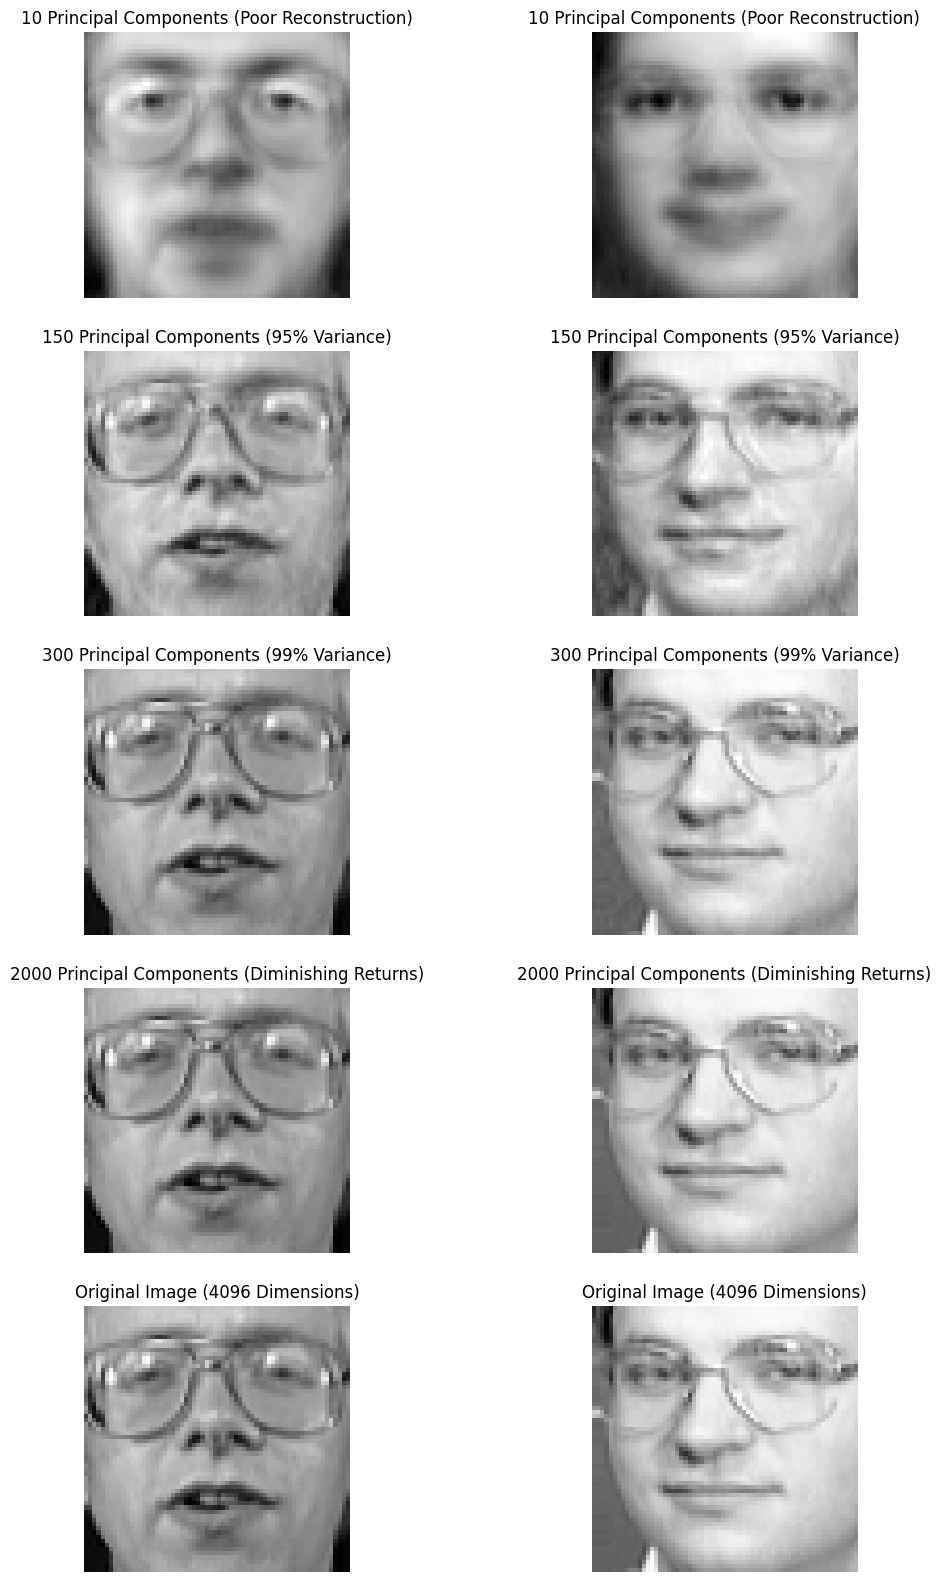

In [14]:
plots = [
    {
        'label': '10 Principal Components (Poor Reconstruction)',
        'L': 10
    },
    {
        'label': '150 Principal Components (95% Variance)',
        'L': 150
    },
    {
        'label': '300 Principal Components (99% Variance)',
        'L': 300
    },
    {
        'label': '2000 Principal Components (Diminishing Returns)',
        'L': 2000
    },
    {
        'label': 'Original Image (4096 Dimensions)',
        'L': 4096
    }
]

fig, axes = plt.subplots(len(plots), 2, figsize=(12, 20))

for i in range(len(plots)):
    label = plots[i]['label']
    L = plots[i]['L']
    
    axes[i][0].set_title(label)
    axes[i][0].imshow((project(sorted_eigenvectors[:, :L], X[:, 10]) + mu).reshape(64, 64), cmap="gray")  # Project the 11th mean-centered face onto the principal components, and then add the mean
    axes[i][0].axis("off")

    axes[i][1].set_title(label)
    axes[i][1].imshow((project(sorted_eigenvectors[:, :L], X[:, 58]) + mu).reshape(64, 64), cmap="gray")  # Project the 59th mean-centered face onto the principal components, and then add the mean
    axes[i][1].axis("off")

# Similarity between SVD and PCA

Performing PCA corresponds to picking the left singular vectors with the biggest singular values.

In [15]:
U, SIGMA, VT = np.linalg.svd(X)

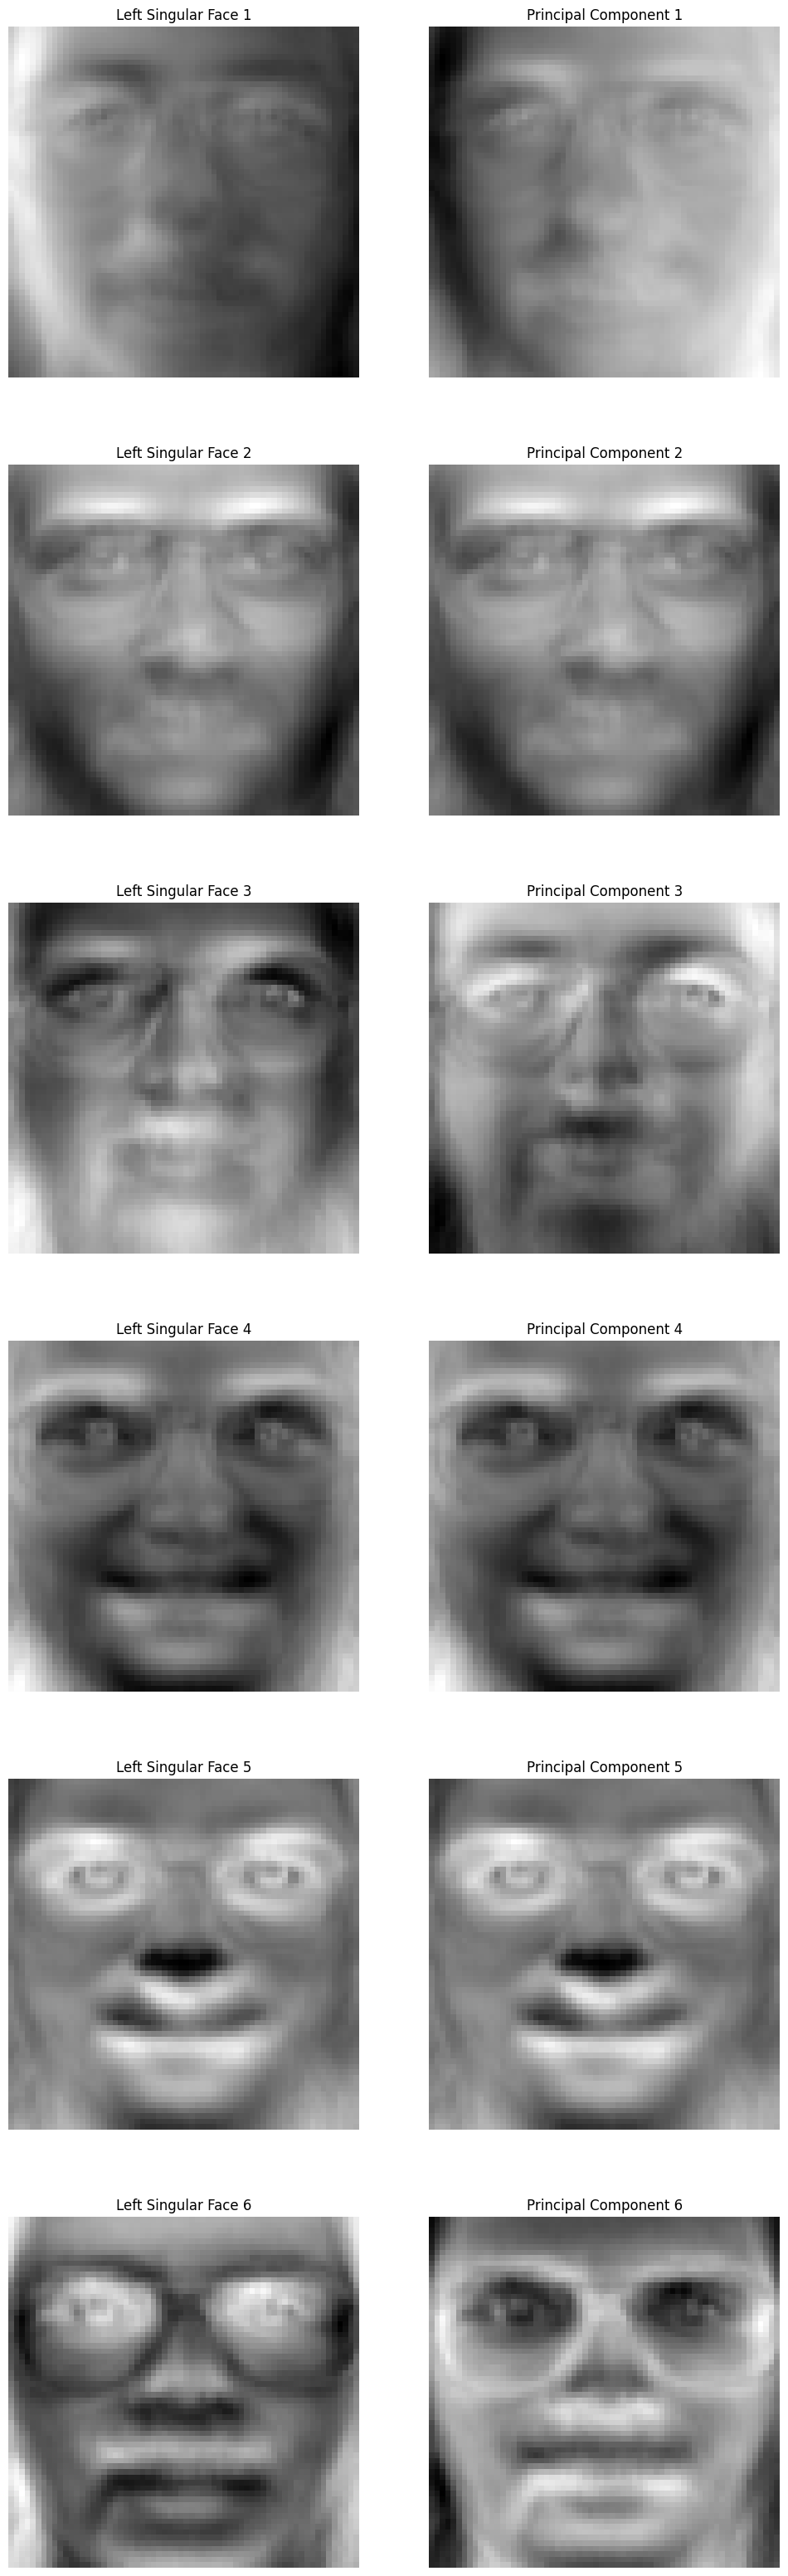

In [16]:
fig, axes = plt.subplots(6, 2, figsize=(12, 40))

for i in range(12):
    title = "Left Singular Face " if i % 2 == 0 else "Principal Component "
    title += str((i // 2) + 1)
    axes[i // 2][i % 2].set_title(title)
    axes[i // 2][i % 2].imshow((U[:, (i // 2) + 1] if i % 2 == 0 else sorted_eigenvectors[:, (i // 2) + 1]).reshape(64, 64), cmap="gray")
    axes[i // 2][i % 2].axis("off")

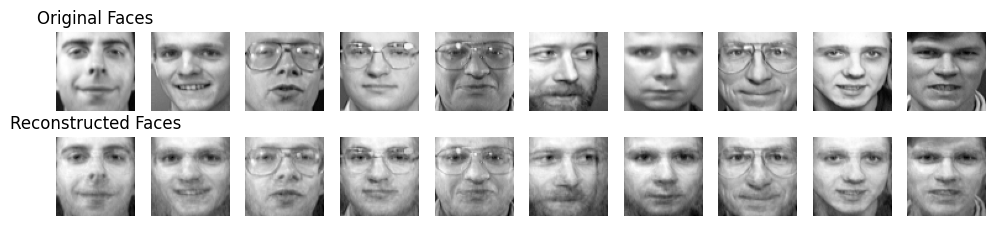

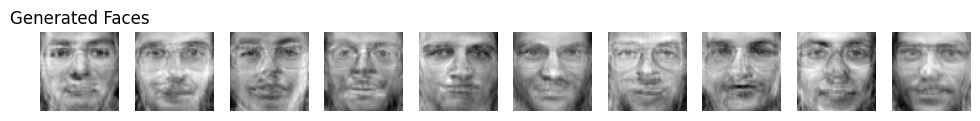

In [30]:
cols_idx = np.random.choice(X.shape[1], size=10)

alpha = X[:, cols_idx] + mu
reconstructed = project(W_pca, alpha) + mu

generated = np.random.multivariate_normal(mu_list, C, size=10).T

# Visualize original and reconstructed faces
fig, axes = plt.subplots(2, 10, figsize=(12, 2.5))
axes[0, 0].set_title("Original Faces")
axes[1, 0].set_title("Reconstructed Faces")
for i in range(10):
    axes[0, i].imshow(alpha[:, i].reshape(64, 64), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[:, i].reshape(64, 64), cmap='gray')
    axes[1, i].axis('off')
plt.show()

# Visualize generated faces
fig, axes = plt.subplots(1, 10, figsize=(12, 2.5))
for i in range(10):
    axes[i].imshow(generated[:, i].reshape(64, 64), cmap='gray')
    axes[i].axis('off')
axes[0].set_title("Generated Faces")
plt.show()